In [2]:
import os
import sys
from pathlib import Path

# Get the project root directory (2 levels up from notebooks)
project_root = str(Path().absolute().parent.parent)
print(f"Adding to path: {project_root}")

# Add to Python path
if project_root not in sys.path:
    sys.path.append(project_root)

Adding to path: /Users/leowalker/Documents/Projects/PathAtlas


In [2]:
from backend.database.mongodb_jobfocus import mongodb, get_jobs_collection, get_searches_collection

# Test connection
try:
    jobs_collection = get_jobs_collection()
    searches_collection = get_searches_collection()
    print("MongoDB collections accessible")
    
    # Test indexes
    mongodb.ensure_indexes()
    print("Indexes created")
except Exception as e:
    print(f"MongoDB connection error: {e}")

MongoDB collections accessible
Indexes created


In [3]:
# Test API fetch
from backend.utils.job_search import fetch_jobs_from_api

response = fetch_jobs_from_api(
    job_title="Python Developer",
    job_location="San Francisco"
)

if response:
    print("API Response received")
    print(f"Response keys: {response.keys()}")
    print(f"Number of jobs found: {len(response.get('jobs', []))}")
else:
    print("API fetch failed")

API Response received
Response keys: dict_keys(['search_metadata', 'search_parameters', 'search_information', 'jobs', 'pagination'])
Number of jobs found: 10


{'search_metadata': {'id': 'search_LMG6OPWeEVjFoA1YX4jR8w7N',
  'status': 'Success',
  'created_at': '2025-01-05T18:15:53Z',
  'request_time_taken': 1.21,
  'parsing_time_taken': 0.2,
  'total_time_taken': 1.41,
  'request_url': 'https://www.google.com/search?q=Python+Developer+San+Francisco&oq=Python+Developer+San+Francisco&gl=us&hl=en&udm=8&jbr=sep:0',
  'html_url': 'https://www.searchapi.io/api/v1/searches/search_LMG6OPWeEVjFoA1YX4jR8w7N.html',
  'json_url': 'https://www.searchapi.io/api/v1/searches/search_LMG6OPWeEVjFoA1YX4jR8w7N'},
 'search_parameters': {'engine': 'google_jobs',
  'q': 'Python Developer San Francisco',
  'google_domain': 'google.com',
  'hl': 'en',
  'gl': 'us'},
 'search_information': {'query_displayed': 'Python Developer San Francisco',
  'detected_location': 'San Francisco, CA'},
 'jobs': [{'position': 1,
   'title': 'Python Developer (10+ Years)',
   'company_name': 'Agile Datapro',
   'location': 'San Francisco, CA',
   'via': 'via SitePoint',
   'description
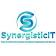
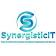
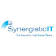
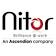
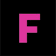
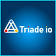

In [4]:
response

-------

In [5]:
from pydantic import ValidationError
from backend.models.job_search_models import JobSearchResponse

# Debug the raw response structure
print("Raw Response Keys:", response.keys())
print("\nSample of response data:")
for key, value in response.items():
    if isinstance(value, (list, dict)):
        print(f"{key}: {type(value)} with {len(value)} items")
    else:
        print(f"{key}: {value}")

# Debug the parsing error with more detail
if response:
    try:
        parsed = JobSearchResponse(**response)
    except ValidationError as e:
        print("Validation Errors:")
        for error in e.errors():
            print(f"Field: {error['loc']}")
            print(f"Error: {error['msg']}")
            print(f"Type: {error['type']}\n")

Raw Response Keys: dict_keys(['search_metadata', 'search_parameters', 'search_information', 'jobs', 'pagination'])

Sample of response data:
search_metadata: <class 'dict'> with 9 items
search_parameters: <class 'dict'> with 5 items
search_information: <class 'dict'> with 2 items
jobs: <class 'list'> with 10 items
pagination: <class 'dict'> with 1 items


In [6]:
# Test response parsing
from backend.utils.job_search import parse_jobs_response

# Test parsing with updated models
if response:
    parsed = parse_jobs_response(response)
    if parsed:
        print(f"Found {len(parsed.jobs)} jobs")
        first_job = parsed.jobs[0]
        print("\nFirst job details:")
        print(f"Title: {first_job.title}")
        print(f"Company: {first_job.company_name}")
        print(f"Location: {first_job.location}")
    else:
        print("Failed to parse response")

Found 10 jobs

First job details:
Title: Python Developer (10+ Years)
Company: Agile Datapro
Location: San Francisco, CA


{'jobs': [{'apply_link': HttpUrl('https://www.sitepoint.com/jobs-for-developers/agile-datapro/python-developer-10-years-1343451/?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic'),
           'apply_links': [{'link': HttpUrl('https://www.sitepoint.com/jobs-for-developers/agile-datapro/python-developer-10-years-1343451/?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic'),
                            'source': 'SitePoint'},
                           {'link': HttpUrl('https://jobs.wbtw.com/jobs/python-developer-10-years-san-francisco-california/1538036752-2/?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic'),
                            'source': 'WBTW Jobs'},
                           {'link': HttpUrl('https://jobs.lilylifestyle.co.uk/jobs/python-developer-10-years-san-francisco-california/1538036752-2/?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic'),
              
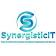
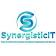
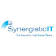
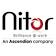
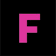
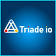

In [8]:
from pprint import pprint
pprint(parsed.model_dump())

In [9]:
# Test different search combinations
test_searches = [
    {"job_title": "Python Developer", "job_location": "Remote"},
    {"job_title": "Data Scientist", "job_location": "San Francisco"},
    {"job_title": "Software Engineer", "job_location": "New York"}
]

for search in test_searches:
    response = fetch_jobs_from_api(**search)
    if response:
        parsed = parse_jobs_response(response)
        print(f"\nSearch for {search['job_title']} in {search['job_location']}:")
        print(f"Found {len(parsed.jobs)} jobs")


Search for Python Developer in Remote:
Found 10 jobs

Search for Data Scientist in San Francisco:
Found 10 jobs

Search for Software Engineer in New York:
Found 10 jobs


In [12]:
# Delete all documents from both collections
from backend.database.mongodb_jobfocus import get_jobs_collection, get_searches_collection

def clear_collections():
    """Clear all documents from jobs and searches collections."""
    try:
        jobs_collection = get_jobs_collection()
        searches_collection = get_searches_collection()
        
        # Get counts before deletion
        jobs_count = jobs_collection.count_documents({})
        searches_count = searches_collection.count_documents({})
        
        # Delete all documents
        jobs_result = jobs_collection.delete_many({})
        searches_result = searches_collection.delete_many({})
        
        print(f"Deleted {jobs_result.deleted_count}/{jobs_count} documents from job_listings")
        print(f"Deleted {searches_result.deleted_count}/{searches_count} documents from job_searches")
        
        return True
    except Exception as e:
        print(f"Error clearing collections: {e}")
        return False

# Execute the cleanup
clear_collections()

Deleted 10/10 documents from job_listings
Deleted 1/1 documents from job_searches


True

In [13]:
# Verify collections are empty
jobs_collection = get_jobs_collection()
searches_collection = get_searches_collection()

print(f"Jobs remaining: {jobs_collection.count_documents({})}")
print(f"Searches remaining: {searches_collection.count_documents({})}")

Jobs remaining: 0
Searches remaining: 0


In [3]:
# Test with detailed error logging
from backend.utils.job_search import fetch_jobs_from_api, parse_jobs_response, store_jobs_in_db

response = fetch_jobs_from_api(
    job_title="AI Engineer",
    job_location="Palo Alto CA"
)

if response:
    parsed = parse_jobs_response(response)
    if parsed:
        print(f"Found {len(parsed.jobs)} jobs")
        success = store_jobs_in_db(parsed)
        print(f"Storage successful: {success}")

Found 10 jobs
1. Attempting to store search metadata...
2. Successfully stored search metadata with ID: 677ad4e4930df55d9a5dcb9d
3. Attempting to store jobs...
4. Stored job: Lead AI engineer (Stealth humanoid startup)
4. Stored job: Applied AI Engineer, USA - Palo Alto (Mistral AI)
4. Stored job: AI Engineer & Researcher - Human Data (xAI)
4. Stored job: Sr Site Reliability Engineer (AI Runtime Security) (Palo Alto Networks)
4. Stored job: Applied AI Engineer (hybrid) (Roadz)
4. Stored job: AI Research Engineer, Generative Modeling, Self-Driving (Tesla)
4. Stored job: AI Engineer & Researcher - Data (xAI)
4. Stored job: Staff AI Research Engineer, Computer Vision (Rivian and VW Group Technology)
4. Stored job: Senior AI Engineer (US) (Rhythms)
4. Stored job: AI Engineer (Chai)
5. Successfully stored 10/10 jobs
Storage successful: True
